In [1]:
import numpy as np
import torch

from torch import nn
import pandas as pd
from IPython.display import Audio
import seaborn as sns
import tqdm
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
sns.set()

%load_ext autoreload
%autoreload 2

In [2]:
import utils
import models
import trainer
import mclnn

In [3]:
class conf:
    # Preprocessing settings
    sampling_rate = 44100
    duration = 2
    hop_length = 347*duration # to make time steps 128
#     hop_length = 694*duration
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    samples = sampling_rate * duration
    trim_long_data=True

In [4]:
conf.columns, conf.column_encoder = utils.read_columns()

In [5]:
all_x, all_y, _ = torch.load("./train_curated_preprocessed.tc")
# all_x, all_y, _ = utils.read_dataset("./data/train_curated", conf, lambda s: utils.audio_to_melspectrogram(conf, s))

In [6]:
np.random.seed(42)
train_x, test_x, train_y, test_y = train_test_split(all_x, all_y, test_size=0.1)

In [7]:
train_dataset = trainer.SoundDataset(train_x, train_y)
test_dataset = trainer.SoundDataset(test_x, test_y)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=trainer.collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=trainer.collate_fn, shuffle=True)

In [52]:
model = nn.Sequential(
    mclnn.CLNNModule(128, 256, 4, dilation=1, mask_params={"bandwidth":64, "overlap":32}),
    nn.LeakyReLU(),
    mclnn.BatchNorm(256),
    mclnn.CLNNModule(256, 256, 4, dilation=1, mask_params={"bandwidth":64, "overlap":32}),
    nn.LeakyReLU(),
    mclnn.TemporalPool(2),
    mclnn.BatchNorm(256),
    mclnn.CLNNModule(256, 256, 4, dilation=1),
    nn.LeakyReLU(),
    mclnn.TemporalPool(2),
    mclnn.CLNNModule(256, 256, 4),
    nn.LeakyReLU(),
    mclnn.TemporalPool(4),
    mclnn.BatchNorm(256),
    mclnn.Flatten(),
    nn.Linear(256*8, 1024),
    nn.LeakyReLU(),
    nn.Linear(1024, len(conf.columns))
)

In [53]:
device = torch.device("cuda")

model = model.to(device)

In [54]:
def optimizer_factory(params):
    result = torch.optim.Adam(params, lr=1e-3)
    return result
    
def scheduler_factory(optimizer):
    result = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5)
    return result

In [55]:
tr = trainer.Trainer(model, optimizer_factory, scheduler_factory, device, {"path":"./experiments/paper/"})

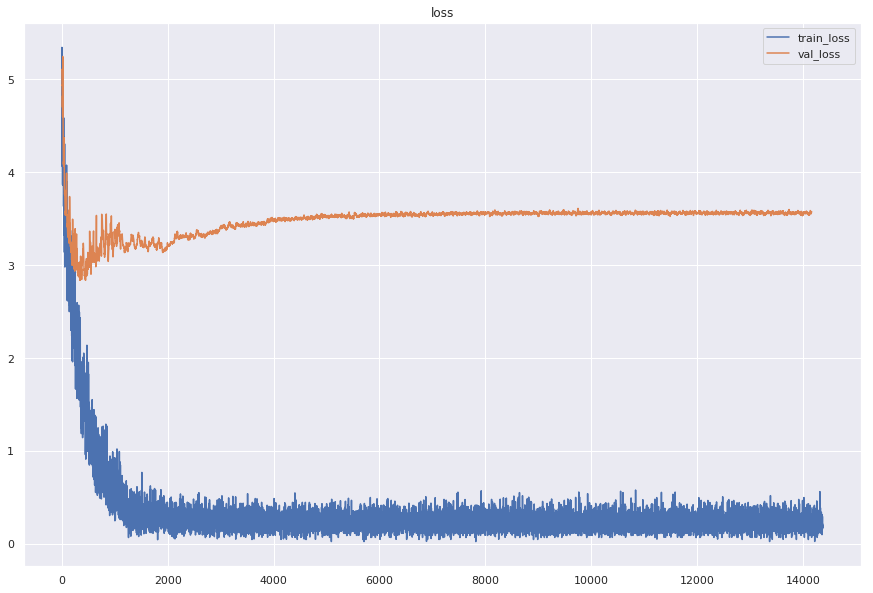

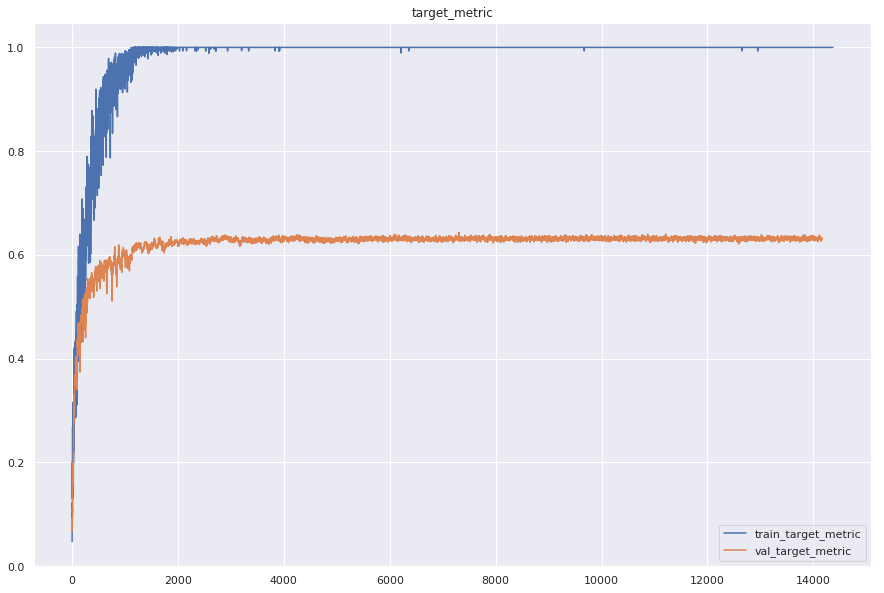

In [63]:
tr.train(
    loaders={"train_loader":train_loader, "test_loader":test_loader},
    params={"epochs":100, "grad_clip_norm":10.0, "validate_every":25},
)

In [64]:
tr.save_path

'./experiments/paper/2019-06-16.11.19.18'

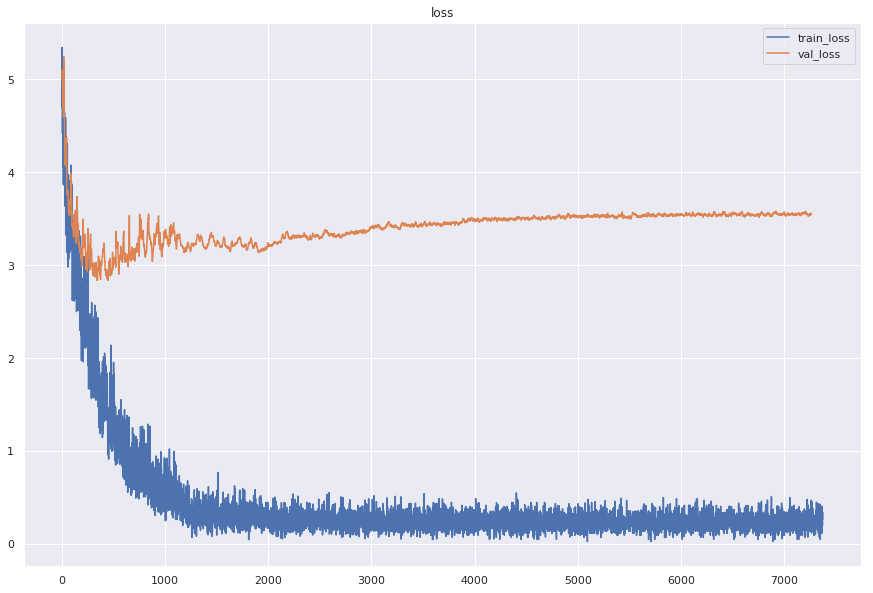

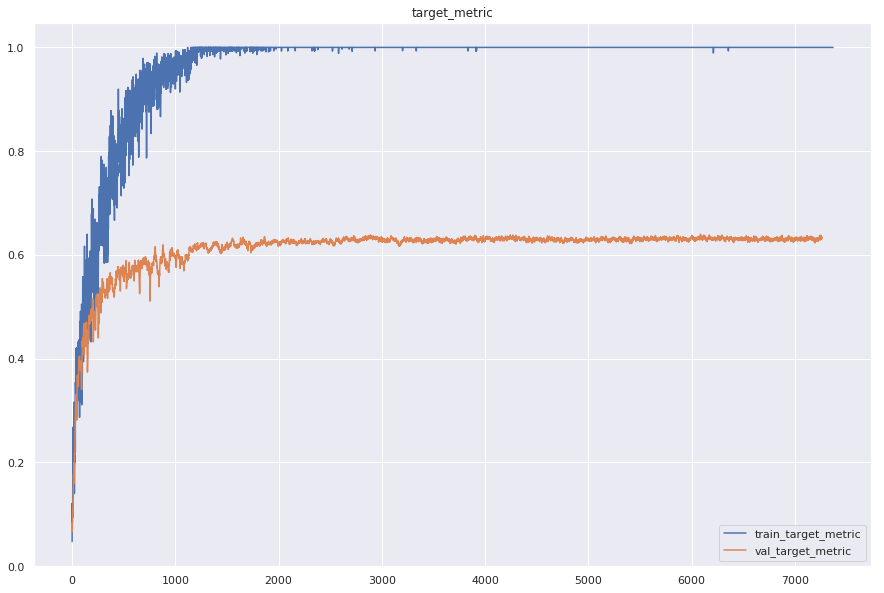

In [62]:
tr.plot(tr.train_metrics, tr.val_metrics)

In [66]:
tr.val_metrics['target_metric'][:300]

[0.06624228526948643,
 0.0778159036809336,
 0.0826429180862273,
 0.09894963647518329,
 0.1046179552952032,
 0.11126972631608543,
 0.1049986408643899,
 0.1195298563876137,
 0.12255691903580887,
 0.13335639821890455,
 0.14251322632229557,
 0.14852960163244647,
 0.16115613393665182,
 0.17746783493167848,
 0.16795952626831348,
 0.1587541272825874,
 0.19868617193743426,
 0.17266294813257496,
 0.17161661241222412,
 0.18231120603078538,
 0.18788718129381338,
 0.19971636433327608,
 0.1985194865827069,
 0.21648901251364244,
 0.21539004032343403,
 0.23601348745030074,
 0.24553588829638756,
 0.25568706263000185,
 0.28111588211229105,
 0.29275728239486887,
 0.3025325506656222,
 0.3054063428695589,
 0.32083364137991405,
 0.3234569984509013,
 0.32865139824281436,
 0.33079606693872415,
 0.3229324981212154,
 0.31762530278965473,
 0.30941859689852236,
 0.3044735533928762,
 0.31074931010057716,
 0.3048905155026679,
 0.2877311423661835,
 0.2817483957358604,
 0.2900878346541925,
 0.313439892378845,
 0.329